1RSB
===

\begin{align*}
p\left(u\right)  &= \sum_{h_{1},\dots,h_{k}}\delta\left(u;\min_{j=1,\dots,k}\left|h_{j}\right|\prod_{j=1}^{k}\text{sign}\left(h_{j}\right)\right)\prod_{j=1}^{k}q_j\left(h_{j}\right)e^{y C_{ai}}\\
q(h) &= \sum_{u_1,\dots,u_d} \prod_{b=1,\dots,d} p_b(u_b) \delta\left(h-s-\sum_{b=1,\dots,d}u_b\right)e^{y C_{ia}}\\
\end{align*}

where
\begin{align*}
C_{ai} &= 0\\% -2\min_{j=1,\dots,k}|h_{j}|\Theta\left(-\prod_{j=1}^kh_{j}\right)\\
C_{ia} &=\left|s + \sum_{b=1}^d u_b\right| - \sum_{b=1}^d|u_b| = |h| - \sum_{b=1}^d|u_b|
\end{align*}



In [1]:
using OffsetArrays

const ∏ = prod
const ∑ = sum

sum (generic function with 14 methods)

In [251]:
function iter_slow_factor(Q, J, y=0.0)
    k = length(Q)
    p = fill(0.0, -J:J)
    for hs in Iterators.product(fill(-J:J,k)...)
        w = ∏(q[h] for (q,h) ∈ zip(Q,hs))
        u = minimum(abs.(hs))*sign(∏(hs))
        p[clamp(u, -J, J)] += w
    end
    p ./= sum(p)
end

function iter_slow_var(P, s, J, y=0.0) 
    q = fill(0.0, -J:J)
    for us in Iterators.product(fill(-J:J, length(P))...)
        h = sum(us) + s
        Cia = abs(h) - sum(abs.(us)) 
        w = ∏(p[u] for (p,u) ∈ zip(P,us)) * exp(y*Cia)
        q[clamp(h, -J, J)] += w 
    end
    q
end

iter_slow_var (generic function with 2 methods)

Simplifications
--

\begin{align*}
p\left(u\right)= & \sum_{h_{1},\dots,h_{k}}\delta\left(u;\min_{j=1,\dots,k}\left|h_{j}\right|\prod_{j=1}^{k}\text{sign}\left(h_{j}\right)\right)\prod_{j=1}^{k}q_j\left(h_{j}\right)\\%e^{-y 2 u \Theta(-u)}\\
\end{align*}

To compute $p$, define

\begin{align*}
a_k(u) &= \mathbb{P}\left\{\left(\textrm{sign}\left(\prod_{i=1}^k h_i\right)=\textrm{sign}(u) \right)\wedge \left(|h_1|,\dots,|h_k| \ge |u|\right)\right\}\\
\end{align*}

$a_k$ satisfies the recursion

\begin{align*}
a_0(u) &= \delta(\textrm{sign}(u)-1)\\
a_k(u) &= a_{k-1}(u) \sum_{h_k\geq |u|}q_k(h_k) + a_{k-1}(-u) \sum_{h_k \leq -|h|} q_k(h_k)\\
\end{align*}

Then we finally have

$$p_k(u) = \cases{(a_k(u)-a_k(u+\textrm{sign}(u))) & for $u\neq0$\\
           1-\prod_{j=1}^k(1-q_j(0)) & for $u=0$}$$


In [632]:
function iter_factor(Q, J, y=0.0)
    a = fill(0.0, -J-1:J+1)
    a[0:J] .= 1
    mass = 1.0
    for q ∈ Q
        Σp, Σm = 0.0, 0.0
        for h=J:-1:1
            ap, am = a[h], a[-h]
            Σp += q[h]; Σm += q[-h]
            a[+h] = ap*Σp + am*Σm
            a[-h] = am*Σp + ap*Σm
        end
        a[0] *= Σp + Σm
        mass *= Σp + Σm + q[0]
    end
    
    p = fill(0.0, -J:J)
    for u = 1:J
        p[+u] = a[+u] - a[+u+1]
        p[-u] = a[-u] - a[-u-1]
    end
    p[0] = mass-a[0]
    p ./= sum(p)
end

function Cached_Factor_Iterator(J)
    a = fill(0.0, -J-1:J+1)
    function iter_factor!(p, Q)
        a[0:J] .= 1
        a[-J:-1] .= 0
        mass = 1.0
        @assert extrema(eachindex(p)) == (-J,J)
        @inbounds for q ∈ Q
            @assert extrema(eachindex(q)) == (-J,J)
            Σp, Σm = 0.0, 0.0
            for h=J:-1:1
                ap, am = a[h], a[-h]
                Σp += q[h]; Σm += q[-h]
                a[+h] = ap*Σp + am*Σm
                a[-h] = am*Σp + ap*Σm
            end
            a[0] *= Σp + Σm
            mass *= Σp + Σm + q[0]
        end
        @inbounds for u = 1:J
            p[+u] = a[+u] - a[+u+1]
            p[-u] = a[-u] - a[-u-1]
        end
        p[0] = mass-a[0]
        p ./= sum(p)
    end
end


Cached_Factor_Iterator (generic function with 1 method)

Comparison
--

In [633]:
J=10
y=0.1
Q=[(q=fill(0.0,-J:J); q[-J:J] .= rand(2J+1); q) for i=1:1]
p = fill(0.0, -J:J)
iter_factor! = Cached_Factor_Iterator(J)
[iter_factor(Q,J,y) iter_slow_factor(Q,J,y) iter_factor!(p,Q)]

21×3 Matrix{Float64}:
 0.0941052    0.0941052    0.0941052
 0.029434     0.029434     0.029434
 0.0189603    0.0189603    0.0189603
 0.0634588    0.0634588    0.0634588
 0.0885798    0.0885798    0.0885798
 0.088366     0.088366     0.088366
 0.0920124    0.0920124    0.0920124
 0.00358952   0.00358952   0.00358952
 0.0212609    0.0212609    0.0212609
 0.0489629    0.0489629    0.0489629
 0.0589469    0.0589469    0.0589469
 0.0890563    0.0890563    0.0890563
 0.000178091  0.000178091  0.000178091
 0.0415348    0.0415348    0.0415348
 0.00479548   0.00479548   0.00479548
 0.0785914    0.0785914    0.0785914
 0.00822049   0.00822049   0.00822049
 0.0684       0.0684       0.0684
 0.0240628    0.0240628    0.0240628
 0.0737238    0.0737238    0.0737238
 0.00376017   0.00376017   0.00376017

In [634]:
using BenchmarkTools
@btime iter_factor!(p,Q)

  148.217 ns (0 allocations: 0 bytes)


21-element OffsetArray(::Vector{Float64}, -10:10) with eltype Float64 with indices -10:10:
 0.0941052232119461
 0.02943401827191216
 0.0189602577881058
 0.06345875078953656
 0.08857984772159544
 0.08836600060425563
 0.0920123981445503
 0.00358952101437341
 0.021260858211006393
 0.048962893125339926
 0.05894690046553584
 0.08905634147336772
 0.00017809118672601756
 0.04153477237505282
 0.004795482515862441
 0.07859137269024613
 0.00822049207006807
 0.06840001971884936
 0.02406283395398755
 0.07372375954016772
 0.003760165127514612

The expression for $C_{ia}$ is

\begin{align*}
    C_{ia} &=\left|s + \sum_{b=1}^d u_b\right| - \sum_{b=1}^d|u_b|
\end{align*}
and

\begin{align*}
q(h) &= \sum_{u_1,\dots,u_d} \prod_{b=1,\dots,d} p_b(u_b) \delta\left(h-s-\sum_{b=1}^du_b\right)e^{y C_{ia}}\\
&= e^{y |h|}\sum_{u_1,\dots,u_d} \prod_{b=1,\dots,d} p_b(u_b)e^{-y|u_b|} \delta\left(h-s-\sum_{b=1}^du_b\right)\\
\end{align*}


To compute $q_d$, note that

\begin{align}
q(h) &= q_d(h)e^{y|h|}
\end{align}

where $q_d$ satisfies
\begin{align}
q_0(h) & = \delta(h-s)\\
q_d(h) & = \sum_{u} q_{d-1}(h-u) p_d(u)e^{-y|u|} 
\end{align}

In [258]:
function ⊛(p1, p2)
    q = fill(0.0,firstindex(p1)+firstindex(p2):lastindex(p1)+lastindex(p2))
    for u2 in eachindex(p2), u1 in eachindex(p1)
        q[u1+u2] += p1[u1]*p2[u2]
    end
    q
end

function iter_var(P, s, J, y=0.0)
    q = fill(1.0, s:s)
    for p ∈ P
        q = q ⊛ (p .* exp.(-y .* abs.(eachindex(p))))
    end
    q .*= exp.(y .* abs.(eachindex(q)))
    qnew = fill(0.0, -J:J)
    for h in eachindex(q)
        qnew[clamp(h,-J,J)] += q[h]
    end
    qnew
end

iter_var (generic function with 2 methods)

In [ ]:
function Cached_Var_Iterator(J, maxd, y)
    buf = (zeros(maxd*2J+1), zeros(maxd*2J+1))
    expy = OffsetArray([exp(y*abs(h)) for h=-maxd*J-1:maxd*J+1], -maxd*J-1:maxd*J+1)
    expmy = OffsetArray([exp(-y*abs(h)) for h=-J:J], -J:J)
    function iter_var!(q, P, s)
        @assert length(P) ≤ maxd
        first = last = s
        q1, q2 = buf[1], buf[2]
        q1[1] = 1.0
        @inbounds for (i,p) in enumerate(P)
            #q2[1:last-first+1+2J] .= 0
            q2 .= 0
            for u2 = eachindex(p)
                paux = p[u2] * expmy[u2]
                for u1 = 1:last-first+1
                    q2[u1+u2+J] += q1[u1] * paux
                end
            end
            first -= J
            last += J
            q1, q2 = q2, q1
        end
        q .= 0
        @inbounds for (h,h1) in enumerate(first:last)
            q[clamp(h1,firstindex(q),lastindex(q))] += q1[h] * expy[h1]
        end
        #q ./= sum(q)
        q
    end
end

Comparison
--

In [635]:
J=13
y=0.0
s=1
maxd = 2
P=[(p=fill(0.0, -J:J); p[-J:J] .= rand(2J+1); p ) for i=1:maxd]
iter_var! = Cached_Var_Iterator(J, maxd, y)
q= fill(0.0, -J:J)
[iter_var(P,s,J,y) iter_slow_var(P,s,J,y) iter_var!(q,P,s)]

27×3 Matrix{Float64}:
 20.0454   20.0454   20.0454
  3.67564   3.67564   3.67564
  4.20568   4.20568   4.20568
  4.26205   4.26205   4.26205
  5.07395   5.07395   5.07395
  4.85127   4.85127   4.85127
  5.07144   5.07144   5.07144
  5.59043   5.59043   5.59043
  5.53604   5.53604   5.53604
  6.14677   6.14677   6.14677
  5.67517   5.67517   5.67517
  6.7422    6.7422    6.7422
  7.18242   7.18242   7.18242
  ⋮                  
  7.0973    7.0973    7.0973
  7.21476   7.21476   7.21476
  6.5933    6.5933    6.5933
  6.27051   6.27051   6.27051
  6.35842   6.35842   6.35842
  6.30639   6.30639   6.30639
  5.96154   5.96154   5.96154
  6.29886   6.29886   6.29886
  5.83681   5.83681   5.83681
  5.67674   5.67674   5.67674
  4.90193   4.90193   4.90193
 31.937    31.937    31.937

In [584]:
using BenchmarkTools
@btime iter_var!(q,P,s)

  782.864 ns (0 allocations: 0 bytes)


27-element OffsetArray(::Vector{Float64}, -13:13) with eltype Float64 with indices -13:13:
 23.650294540299925
  3.5530562238920247
  3.6476696469257543
  4.5335649606361565
  4.797672029071193
  5.546558232089177
  5.779757009449599
  5.741735177229007
  6.525425010259815
  7.098215702576697
  7.227601098770833
  6.858026684791501
  7.004481621481139
  ⋮
  7.780200584232243
  8.430628011658207
  7.380061599701225
  7.547962322269083
  8.363747435237505
  7.355404631632143
  6.7887652973817145
  5.700437593617245
  5.824624909630281
  6.031871501011732
  4.963979888362026
 40.96120959803573

In [639]:
using StatsBase, ProgressMeter, Random
ProgressMeter.ijulia_behavior(:append)

residual(x) = (p=OffsetVector((x .* eachindex(x))[1:end], 0:lastindex(x)-1); p./=sum(p))

function moments!(avp, popP)
    avp .= sum(popP, dims=2)[:,1] ./ size(popP,2)
end

function checkRS(popP)
    V=0.0
    for t=1:size(popP,2)
        m1 = sum(i*popP[i,t] for i in eachindex(popP[:,t]))
        m2 = sum(i^2*popP[i,t] for i in eachindex(popP[:,t]))
        V+= m2-m1^2
    end
    V /= size(popP,2)
end

function RSB(Λ, K; 
        J=10, 
        maxiter=100, 
        popsize=1000, 
        tol=1/(J*√popsize),
        popP = fill(1/(2J+1), -J:J, 1:popsize),
        popQ = fill(1/(2J+1), -J:J, 1:popsize), 
        y=0.0)
    J = lastindex(popP[:,1])
    mt = MersenneTwister()
    function Sampler(P, R)
        idx = fill(0,10)
        wP = weights(P)
        function s()
            d = sample(mt, eachindex(P), wP)
            resize!(idx, d)
            rand!(mt, idx, R)
        end
    end
    N = size(popP,2)
    sampled = Sampler(residual(Λ), 1:N)
    samplek = Sampler(residual(K), 1:N)
    iter_var! = Cached_Var_Iterator(J, lastindex(Λ), y)
    iter_factor! = Cached_Factor_Iterator(J)
    avp = fill(0.0, -J:J)
    avp1 = fill(0.0, -J:J)
    moments!(avp, popP); err = Inf
    p = Progress(maxiter)
    for t = 1:maxiter
        for i = 1:N
            P = eachcol(@view popP[:, sampled()])
            s = rand(mt, (-1,1))
            iter_var!((@view popQ[:,i]), P, s)
        end
        for i = 1:N
            Q = eachcol(@view popQ[:, samplek()])
            iter_factor!((@view popP[:,i]), Q)
        end
        moments!(avp1, popP);
        err = maximum(abs.(avp .- avp1))
        if err < tol
            @show t
            break
        end
        ProgressMeter.next!(p; showvalues = [(:err,"$err/$tol")])
        avp, avp1 = avp1, avp
    end
    @show err
    popP, popQ
end

RSB (generic function with 1 method)

In [609]:
Λ = OffsetVector([0,0,0.5,0.5], 0:3)
K = OffsetVector([0,0,0,1], 0:3)

J=10
popsize=10^6
#popP = fill(1/(2J+1), -J:J, 1:popsize);
#popQ = fill(1/(2J+1), -J:J, 1:popsize);
popP = OffsetArray(rand(2J+1, popsize), -J:J, 1:popsize)
popQ = OffsetArray(rand(2J+1, popsize), -J:J, 1:popsize)
popP ./= sum(popP, dims=1);
popQ ./= sum(popQ, dims=1);

In [610]:
popP, popQ = RSB(Λ,K; J=J, maxiter=10^2, popsize=popsize, popQ=popQ, popP=popP, y=0.5);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:21
  err:  0.0009371619657772556/0.0001


err = 0.0009371619657772556


In [586]:
moments(popP), checkRS(popP)

([0.0002311600329646081, 0.0006447106672169076, 0.002054660649366653, 0.005770775214055507, 0.014302564051121226, 0.031153532560384504, 0.05865480366101028, 0.09281561522409171, 0.11994827000986916, 0.12402575386064693  …  0.12393930657626501, 0.11985732683992614, 0.09277502494924883, 0.05865498924992173, 0.03118016873247709, 0.014328448565496057, 0.005787543750054769, 0.0020629090608949305, 0.0006479135170017585, 0.0002326266138175142], 6.979985285712856)

1RSB equations for Max-Sum (Survey Propagation) at finite parameter $y$
---
We consider the auxiliary statistical physics model
\begin{align}
    \mathbb{P}_y(\{u_{ai},h_{ia}\})=\frac{1}{\Theta(y)}\mathbb{I}\left(\{u_{ai},h_{ia}\}\text{sat Max-Sum}\right)e^{-yF(\{u_{ai},h_{ia}\})}
\end{align}
in which the variables are the Max-Sum messages living on the edges, and the constraints (that can be put in a factorized form) enforces the Max-Sum equations to be satisfied. Each Max-Sum solution represents a cluster. The Max-Sum solutions are weighted according to their Bethe free energy, which corresponds to the minimal energy (inside the cluster). In the $y\to\infty$ limit one keeps only the clusters with minimal energy

* The distributions $Q_{ia}(h_{ia})$, $P_{ai}(u_{ai})$ over Max-Sum messages obey the SP(y) equations :
\begin{align}
    Q_{ia}(h_{ia})&=\frac{1}{Z_{ia}}\sum_{\{u_{bi}\}_{b\in\partial i\setminus a}}\delta(h_{ia}-f^{MS}_{ia}(\{u_{bi}\}_{b\in\partial i\setminus a}; s_i))e^{-yC_{ia}}\prod_{b\in\partial i\setminus a}P_{bi}(u_{bi}) \\
    P_{ai}(u_{ai})&=\frac{1}{Z_{ai}}\sum_{\{h_{ja}\}_{j\in\partial a\setminus i}}\delta(u_{ai}-f^{MS}_{ai}(\{h_{ja}\}_{j\in\partial a\setminus i}))e^{-yC_{ai}}\prod_{j\in\partial a\setminus i}Q_{ja}(h_{ja})    
\end{align}
where $h_{ia}-f^{MS}_{ia}(\{u_{bi}\}_{b\in\partial i\setminus a}; s_i)$, and $u_{ai}-f^{MS}_{ai}(\{h_{ja}\}_{j\in\partial a\setminus i})$ are shorthand notation for the Max-Sum equations
\begin{align}
    h_{ia}(\sigma_i)&=s_i\sigma_i+ \sum_{b\in\partial i\setminus a}u_{bi}(\sigma_i) - C_{ia}\\
    u_{ai}(\sigma_i)&=\max_{\{\sigma_j\}_{j\in\partial a\setminus i}:{\rm sat}}\left(\sum_{j\in\partial a\setminus i}h_{ja}(\sigma_j)\right) - C_{ai}
\end{align}
and $C_{ia}$, $C_{ai}$ are the constants in the Max-Sum equations
\begin{align}
    C_{ia}&=\max_{\sigma_i}\left(s_i\sigma_i+ \sum_{b\in\partial i\setminus a}u_{bi}(\sigma_i)\right)\\
    C_{ai}&=\max_{\{\sigma_i\}_{i\in\partial a}:{\rm sat}}\left(\sum_{j\in\partial a\setminus i}h_{ja}(\sigma_j)\right)
\end{align}
the constants $Z_{ia}$, $Z_{ai}$ are normalizations of the distributions $Q_{ia}$, $Q_{ai}$ over the Max-Sum messages. Note that $C_{ia}=F_{(ia)}-F_i$ and $C_{ai} = F_{(ia)} - F_a$.

* With the parametrization $u_{ai}(\sigma_i) = u_{ai}\sigma_i+u_{0,ai}$ and $h_{ia}(\sigma_i) = h_{ia}\sigma_i + h_{0,ia}$ we get :
\begin{equation}
    u_{0,ai} = -\frac{1}{\beta}\log(2{\rm cosh}(\beta u_{ai})\to-|u_{ai}|
\end{equation}
(and the same for $h_{0,ia}$). Therefore :
\begin{align*}
    C_{ia}&=\max_{\sigma_i}\left(\sigma_i\left(s_i+ \sum_{b\in\partial i\setminus a}u_{bi}\right)\right) + \sum_{b\in\partial i\setminus a}u_{0,bi}\\
    &=\left|s_i+ \sum_{b\in\partial i\setminus a}u_{bi}\right| - \sum_{b\in\partial i\setminus a}|u_{bi}|\\
&=|h_{ia}|- \sum_{b\in\partial i\setminus a}|u_{bi}|\\
\end{align*}

and
\begin{align*}
    C_{ai}&=\max_{\{\sigma_i\}_{i\in\partial a}:{\rm sat}}\left(\sum_{j\in\partial a\setminus i}h_{ja}\sigma_j\right)-\sum_{j\in\partial a\setminus i}|h_{ja}|\\
% &= -2\min_{j\in\partial a\setminus i}|h_{ja}|\Theta\left(-\prod_{j\in\partial a\setminus j}h_{ja}\right)
&=0
\end{align*}

* We can then write the same 1RSB equations for the distributions $Q_{ia}(h_{ia})$, $P_{ai}(u_{ai})$ over the integer parameters $h_{ia}$, $u_{ai}$:
\begin{align}
    P(u)&=\frac{1}{Z_P(y)}\sum_{h_1,\dots h_k}\delta\left(u-\min_{j=1\dots,k}|h_j|\prod_j{\rm sgn}(h_j)\right)e^{yC_{ai}(h_1,\dots,h_k)}\prod_j Q_j(h_j) \\
    Q(h)&=\frac{1}{Z_Q(y)}\sum_{u_1,\dots u_d}\delta(h-s-\sum_{b=1}^du_b)e^{yC_{ia}(u_1,\dots,u_d)}\prod_{b=1}^dP_b(u_b)
\end{align}

* Random graph ensemble
When the source and the factor graph are random variables the 1RSB messages $P_{ai}$ for $(a,i)\in E$ become random variables. Let $(a,i)$ be a uniformly chosen edge in a factor graph drawn from the random ensembl, and let $\mathcal{P}$ be the distribution of the message $P_{ai}$ solution of the 1RSB equation written above. The distribution $\mathcal{P}(p)$ obey consistency equation similar to the RS cavity equations:
\begin{align}
    \mathcal{P}^{1RSB}(P)&=\sum_{k}\tilde{P}_k \int\prod_{j=1}^k{\rm d}\mathcal{Q}^{1RSB}(Q_j)\delta(P-F^{SP(y)}(Q_1,\dots,Q_k)) \\
    \mathcal{Q}^{1RSB}(Q) &= \sum_{s}\frac{1}{2}\sum_{d}\tilde{\Lambda_d}\int\prod_{b=1}^d{\rm d}\mathcal{P}^{1RSB}(P_b)\delta(Q-G^{SP(y)}(P_1,\dots,P_d;s))
\end{align}
This equation always admits a trivial fixed point $\mathcal{P}(P)=\sum_u p^{RS}(u)\delta[P-\delta(\cdot-u)]$, $\mathcal{Q}(h)=\sum_h q^{RS}(h)\delta[Q-\delta(\cdot-h)]$, where $p^{RS}, q^{RS}$  is the solution of the RS cavity equation.
In the RS phase, this trivial fixed-point is the unique solution, while in the 1RSB phase, the trivial solution becomes unstable and the above equation admits a non-trivial solution.

Average minimal energy : Free energy of the auxiliary model
---
We want to estimate the Free energy $\mathcal{F}(y)=-\frac{1}{yn}\log\Theta(y)$ of the auxiliary problem defined by the partition function $\Theta(y)$ on a single instance. Then we can average over the random ensemble of instances. In the large $y\to\infty$ limit, we obtain the averaged minimal energy.

On a single instance, once a fixed point of the SP(y) equations has been found on a single instance, one can compute the Bethe free energy of the auxiliary problem:
\begin{align}
    \mathcal{F}(y) = \frac{1}{n}\sum_{a}\mathcal{F}_a(\{Q_{ia}\}_{i\in\partial a};y) + \frac{1}{n}\sum_i\mathcal{F}_i(\{P_{ai}\}_{a\in\partial i};y) - \frac{1}{n}\sum_{(ia)}\mathcal{F}_{(ia)}(P_{ai},Q_{ia};y)
\end{align}
with:
\begin{align}
    \mathcal{F}_a(\{Q_{ia}\}_{i\in\partial a};y) &= -\frac{1}{y}\log\left(\sum_{\{h_{ia}\}_{i\in\partial a}}e^{-yF_a(\{h_{ia}\}_{i\in\partial a})}\prod_{i\in\partial a}Q_{ia}(h_{ia})\right)\\
    \mathcal{F}_i(\{P_{ai}\}_{a\in\partial i};y) &= -\frac{1}{y}\log\left(\sum_{\{u_{ai}\}_{a\in\partial i}}e^{-yF_i(\{u_{ai}\}_{a\in\partial i})}\prod_{a\in\partial i}P_{ai}(u_{ai})\right)\\
    \mathcal{F}_{(ia)}(P_{ai},Q_{ia};y) &= -\frac{1}{y}\log\left(\sum_{u_{ia}, h_{ia}}e^{-yF_{ia}(u_{ia}, h_{ia})}P_{ai}(u_{ai})Q_{ia}(h_{ia})\right)
\end{align}
where $F_a,F_i, F_{ia}$ are the factor, variable and edge terms of the Bethe free energy associated to one fixed point of the Max-Sum equation: 
\begin{align}
    F_a(\{h_{ia}\}_{i\in\partial a}) &= 2\min_{i\in\partial a}|h_{ia}|\Theta(-\prod_i h_{ia})\\
    F_i(\{u_{ai}\}_{a\in\partial i}) &= -|s_i + \sum_{a\in\partial i}u_{ai}| + \sum_a |u_{ai}|\\
    F_{(ia)}(u_{ai},h_{ia}) &= -|u_{ai} + h_{ia}| + |u_{ai}| + |h_{ia}| 
\end{align}
Averaging over the random ensemble of instances:
\begin{align}
    \mathcal{F}^{1RSB}(y) &= \alpha\sum_{k}P_k\int\prod_{i=1}^k{\rm d}\mathcal{Q}^{1RSB}(Q_i)\mathcal{F}_a(Q_1,\dots,Q_k;y) + \sum_d\Lambda_d\sum_s\frac{1}{2}\int\prod_{i=1}^d\mathcal{P}^{1RSB}(P_i)\mathcal{F}_i(P_1,\dots,P_d;s,y) \\
    &- \Lambda'(1)\int\mathcal{F}_{(ia)}\mathcal{P}^{1RSB}(P)\mathcal{Q}^{1RSB}(Q)(P,Q;y)
\end{align}


In [411]:
function overlap_slow_factor(Q, J, y=0.0)
    z = 0.0
    o = 0.0
    k = length(Q)
    for hs in Iterators.product(fill(-J:J,k)...)
        Fa = 2*minimum(abs.(hs))*(∏(hs) < 0)
        w = ∏(q[h] for (q,h) ∈ zip(Q,hs)) * exp(-y*Fa)
        z += w
        o += Fa*w
    end
    o / z, log(z)
end

function overlap_slow_var(P, s, J, y=0.0)
    z = 0.0
    o = 0.0
    d = length(P)
    for us in Iterators.product(fill(-J:J,d)...)
        h = sum(us) + s
        Fi = -abs(h) + sum(abs.(us)) 
        w = ∏(p[u] for (p,u) ∈ zip(P,us)) * exp(-y*Fi)
        z += w
        o += Fi*w
    end
    o/z, log(z)
end


function overlap_slow_edge(p, q, J, y=0.0)
    z = 0.0
    o = 0.0
    for h in -J:J, u in -J:J
        Fia = -abs(u+h)+abs(h)+abs(u)
        w = p[u]*q[h]*exp(-y*Fia)
        o += Fia*w
        z += w
    end
    o/z, log(z)
end

overlap_slow_edge (generic function with 2 methods)

In [445]:
function overlap1RSB(Λ, K; 
        popP, 
        popQ, 
        samples=size(popP,2), 
        y=0.0)
    mt = MersenneTwister()
    function Sampler(P, R)
        idx = fill(0,10)
        wP = weights(P)
        function s()
            d = sample(mt, eachindex(P), wP)
            resize!(idx, d)
            rand!(mt, idx, R)
        end
    end
    N = size(popP,2)
    sampled = Sampler(Λ, 1:N)
    samplek = Sampler(K, 1:N)
    J = lastindex(popQ[:,1])
    mK = sum(k*K[k] for k=eachindex(K))
    mΛ = sum(d*Λ[d] for d=eachindex(Λ))
    α = mΛ/mK

    N = size(popP,2)

    O_factor = F_factor = 0.0
    O_var = F_var = 0.0
    O_edge = F_edge = 0.0
    
    cached_overlap_factor = Cached_Overlap_Factor(J)
    cached_overlap_var = Cached_Overlap_Var(J, lastindex(Λ), y)
    progress = Progress(samples)
    for t = 1:samples
        Q = eachcol(@view popQ[:, samplek()])
        o, f = cached_overlap_factor(Q, J, y)
        O_factor += o
        F_factor += f

        P = eachcol(@view popP[:, sampled()])
        s = rand(mt, (-1,1))
        o, f = cached_overlap_var(P, s)
        O_var += o
        F_var += f

        p = popP[:, rand(1:N)]
        q = popQ[:, rand(1:N)]
        o, f = overlap_slow_edge(p, q, J, y)
        O_edge += o
        F_edge += f
        O = -(α*O_factor + O_var - mΛ*O_edge)/t
        F = -1/y*(α*F_factor + F_var - mΛ*F_edge)/t
        ProgressMeter.next!(progress; showvalues = [(:F,F),(:O,O),(:D,(1-O)/2)])
    end
    O = -(α*O_factor + O_var - mΛ*O_edge)/samples
    F = -1/y*(α*F_factor + F_var - mΛ*F_edge)/samples
    C = -O - F
    O,F,C
end

overlap1RSB (generic function with 1 method)

In [636]:
Λ = OffsetVector([0,0,0.1,0.9], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
mK = sum(k*K[k] for k=eachindex(K))
mΛ = sum(d*Λ[d] for d=eachindex(Λ))
α = mΛ/mK
@show R=1-α
J = 20
y = 0.5
popsize=10^6
popP = fill(1/(2J+1), -J:J, 1:popsize);
popQ = fill(1/(2J+1), -J:J, 1:popsize);

R = 1 - α = 0.033333333333333215


In [613]:
RSB(Λ,K; J=J, maxiter=10^2, tol=1e-5, popP=popP, popQ=popQ, popsize=popsize, y=y);
V = checkRS(popP)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:17
  err:  0.00024325634116789674/1.0e-5


err = 0.00024325634116789674


87.33331587548561

In [614]:
popP

21×1000000 OffsetArray(::Matrix{Float64}, -10:10, 1:1000000) with eltype Float64 with indices -10:10×1:1000000:
 0.306218     0.162223     0.264836     …  0.145335     0.473009
 0.0847262    0.323801     0.220326        0.289381     0.0599892
 0.0576416    0.0203528    0.0292824       6.30538e-5   0.0514069
 0.007057     0.0391307    0.00965075      1.41151e-5   0.0041288
 1.43285e-5   0.0014475    0.00159173      4.16633e-6   0.000126977
 1.45364e-5   0.00140367   0.000181674  …  9.0395e-7    9.52979e-5
 2.95308e-5   0.000363503  0.000137484     2.78978e-7   0.000139138
 2.51272e-5   0.000356397  0.000190749     1.58625e-6   0.000153717
 7.88772e-5   0.000365091  0.000228497     2.64535e-5   0.000253197
 7.94012e-5   0.000291971  0.000331946     1.73053e-5   0.000289736
 0.000103646  0.000206558  0.000481483  …  0.000145141  0.000103113
 0.000107978  0.00026301   0.000283704     2.4855e-5    0.00016393
 0.000106556  0.000295766  0.000187291     6.72613e-5   0.000155245
 3.95642e-5   0

Overlap
--

In [615]:
O,F = overlap1RSB(Λ,K; popP=popP, popQ=popQ, y=y, samples=10^6)
Σ = -O - F
D=(1-O)/2
@show R D F Σ;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
  F:  -1.9978700178984445
  O:  0.410314789680398
  D:  0.294842605159801


R = 0.033333333333333215
D = 0.294842605159801
F = -1.9978700178984445
Σ = 1.5875552282180465


In [ ]:
using Unzip
y = 0.2
J = 30

rs = 0:0.1:1
Rs=fill(NaN, eachindex(rs))
Ds=fill(NaN, eachindex(rs))
Fs=fill(NaN, eachindex(rs))

for (i,r) in pairs(rs)
    Λ = [0,1-r,r]
    K = [0,0,1]
    mK = sum(k*K[k] for k=eachindex(K))
    mΛ = sum(d*Λ[d] for d=eachindex(Λ))
    α = mΛ/mK
    popsize=10^6
    popP, popQ = RSB(Λ,K; J=J, maxiter=10^2, popsize=popsize, y=y)
    O,F = overlap1RSB(Λ,K; popP=popP, popQ=popQ, y=y, samples=10^6)
    Σ = -O - F
    D=(1-O)/2
    R=1-α
    @show R D F
    Rs[i],Ds[i],Fs[i] = R, D, F
end

Progress:   1%|▍                                        |  ETA: 0:04:05
4m  err:  0.015628366972304235/3.3333333333333335e-5
Progress:   2%|▉                                        |  ETA: 0:03:55
4m  err:  0.0239865250671249/3.3333333333333335e-5
Progress:   3%|█▎                                       |  ETA: 0:03:49
4m  err:  0.04058893505665981/3.3333333333333335e-5
Progress:   4%|█▋                                       |  ETA: 0:03:46
4m  err:  0.06002813383326219/3.3333333333333335e-5
Progress:   5%|██                                       |  ETA: 0:03:43
4m  err:  0.059971657455157534/3.3333333333333335e-5
Progress:   6%|██▌                                      |  ETA: 0:03:50
4m  err:  0.07764756444918178/3.3333333333333335e-5
Progress:   7%|██▉                                      |  ETA: 0:03:52
4m  err:  0.03507145819270813/3.3333333333333335e-5
Progress:   8%|███▎                                     |  ETA: 0:03:54
4m  err:  0.043116382396125974/3.3333333333333335e-5
Progre

In [652]:
RJ20, DJ20, FJ20 = Rs, Ds, Fs

([0.33333333333333337, 0.29999999999999993, 0.2666666666666666, 0.2333333333333334, 0.19999999999999984, 0.16666666666666663, 0.13333333333333341, 0.10000000000000009, 0.06666666666666654, 0.033333333333333215, NaN], [0.2107845523948087, 0.21773308162764726, 0.22563901300211053, 0.2373247298845913, 0.24664976333380373, 0.4042265254716063, 0.40356023537293084, 0.4018743226338141, 0.4028346129557729, 0.40372358063815, NaN], [0.27813862713924953, 0.18484698724984827, 0.06604724862731054, -0.05568474599463021, -0.2054663361469467, -5.62345569777071, -6.541966006664131, -7.450284396069251, -8.370863800271904, -9.286972362259716, NaN])

In [650]:
Ds

11-element Vector{Float64}:
   0.2107845523948087
   0.21773308162764726
   0.22563901300211053
   0.2373247298845913
   0.24664976333380373
   0.4042265254716063
   0.40356023537293084
   0.4018743226338141
   0.4028346129557729
   0.40372358063815
 NaN

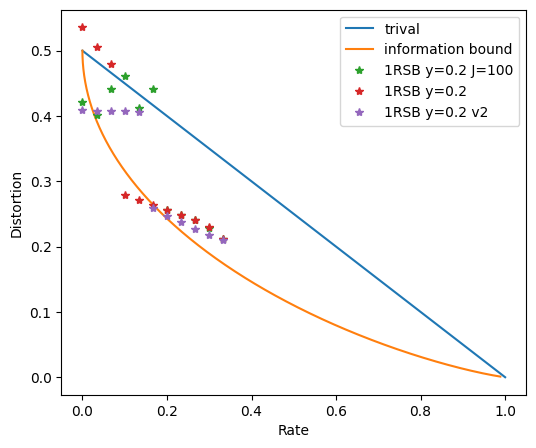

PyObject <matplotlib.legend.Legend object at 0x7f2d93136190>

In [643]:
using PyPlot
H(p)=1+p*log2(p)+(1-p)*log2(1-p)
fig, ax = subplots(figsize=(6,5))
xlabel("Rate")
ylabel("Distortion")
plot((0,1),(0.5,0), label="trival")
plot(H.(0:0.001:0.5), 0:0.001:0.5, label="information bound")
plot(R2,D2, "*", label="1RSB y=0.2")
plot(Rs,Ds, "*", label="1RSB y=0.2 v2")
#plot(R3,D3, "*", label="1RSB y=0.3")
#plot(R4,D4, "*", label="1RSB y=0.4")
#plot(R5,D5, "*", label="1RSB y=0.5")
legend()

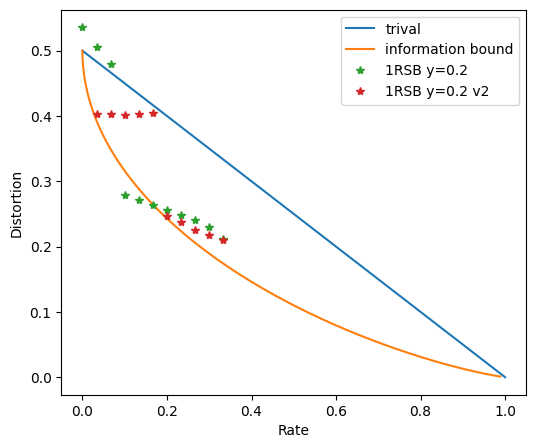

PyObject <matplotlib.legend.Legend object at 0x7f2dbc1df070>

In [651]:
using PyPlot
H(p)=1+p*log2(p)+(1-p)*log2(1-p)
fig, ax = subplots(figsize=(6,5))
xlabel("Rate")
ylabel("Distortion")
plot((0,1),(0.5,0), label="trival")
plot(H.(0:0.001:0.5), 0:0.001:0.5, label="information bound")
plot(R2,D2, "*", label="1RSB y=0.2")
plot(Rs,Ds, "*", label="1RSB y=0.2 v2")
#plot(R3,D3, "*", label="1RSB y=0.3")
#plot(R4,D4, "*", label="1RSB y=0.4")
#plot(R5,D5, "*", label="1RSB y=0.5")
legend()

Simplifications of the terms in the 1RSB Bethe free energy $\mathcal{F}(y)$
---
We can simplify the 1st term
\begin{align}
    \mathcal{F}_a(Q_1,\dots,Q_k;y) &= -\frac{1}{y}\log\left(\mathcal{Z}_a\right)\\
    \mathcal{Z}_a &= \sum_{g_1,\dots,g_k}e^{-2y\min_{i=1,\dots, k}|g_i|\Theta(-\prod_i g_i)}\prod_{i=1}^kQ_i(g_i)
\end{align}
we get:
\begin{align}
    \mathcal{Z}_a &=  \sum_{g_1,\dots,g_k}1-\Theta(-\prod_i g_i) + \Theta(-\prod_i g_i)e^{-2y\min_i|g_i|}\prod_{i=1}^k Q_i(g_i)\\
    &= 1+\sum_{g_1,\dots,g_k}\Theta(-\prod_i g_i)\left(e^{-2y\min_i|g_i|}-1\right)\prod_{i=1}^kQ_i(g_i) \\
    &= 1+ \sum_{f=0}^{\infty}\left(e^{-2yf}-1\right)\sum_{g_1,\dots,g_k}\Theta(-\prod_i g_i)\delta(f-\min_i|g_i|)\prod_{i=1}^kQ_i(g_i)\\
    &= 1+\sum_{f=0}^{\infty}\left(e^{-2yf}-1\right)(a_k(-f)-a_k(-f-1))\\
    &= 1+\sum_{f=1}^{\infty}\left(e^{-2yf}-1\right)(a_k(-f)-a_k(-f-1))
\end{align}



\begin{align}
\mathbb{E}[F_a] &= \frac1{\mathcal{Z}_a} \sum_{h_1,\dots,h_k} 2\min_i|h_i|\Theta(-\prod_i h_i) e^{-2y\min_i|h_i|\Theta(-\prod_i h_i)}\prod_{i=1}^k Q_i(h_i)\\
 &= \frac1{\mathcal{Z}_a} \sum_{h_1,\dots,h_k} 2\min_i|h_i|\Theta(-\prod_i h_i) e^{-2y\min_i|h_i|}\prod_{i=1}^k Q_i(h_i)\\
 &= \frac1{\mathcal{Z}_a} \sum_{h_1,\dots,h_k} 2\min_i|h_i|\Theta(-\prod_i h_i) e^{-2y\min_i|h_i|}\prod_{i=1}^k Q_i(h_i)\\
 &=  \frac1{\mathcal{Z}_a} \sum_{u\geq0}2ue^{-2yu}(a_k(-u)-a_k(-u-1))
\end{align}

In [420]:
function overlap_factor(Q, J, y=1.0)
    a = fill(0.0, -J-1:J+1)
    a[1:J] .= 1
    for q ∈ Q
        Σp, Σm = 0.0, 0.0
        for f=J:-1:1
            ap, am = a[f], a[-f]
            #Σp, Σm = ∑(q[f:N]), ∑(q[-N:-f])
            Σp += q[f]; Σm += q[-f]
            a[+f] = ap*Σp + am*Σm
            a[-f] = am*Σp + ap*Σm
        end
    end
    o = sum((a[-f]-a[-f-1])*2f*exp(-2y*f) for f in 1:J)
    z = 1 + sum((a[-f]-a[-f-1])*(exp(-2*y*f)-1) for f in 1:J)
    o/z, log(max(z,0.0))
end

function Cached_Overlap_Factor(J)
    p = fill(0.0, -J:J)
    F! = Cached_Factor_Iterator(J)
    function overlap(Q, J, y)
        F!(p, Q)
        o = 0.0
        z = 1.0
        for f=1:J
            e = exp(-2y*f)
            o += p[-f]*2f*e
            z += p[-f]*(e-1)
        end
        o/z, log(max(z,0))
    end
end


Cached_Overlap_Factor (generic function with 3 methods)

Comparison
---

In [463]:
J=10
y=0.5
cached_overlap = Cached_Overlap_Factor(J)
Q=[(p=fill(0.0,-J:J); p[-J:J] .= rand(2J+1); p ./=sum(p)) for i=1:3]
[overlap_factor(Q,J,y) overlap_slow_factor(Q,J,y) cached_overlap(Q,J,y)]

1×3 Matrix{Tuple{Float64, Float64}}:
 (0.276262, -0.466795)  (0.276262, -0.466795)  (0.276262, -0.466795)

In [409]:
@btime cached_overlap($Q,J,y)

  744.131 ns (1 allocation: 32 bytes)


(0.09169840477545171, -0.53168793029266)

We can also simplify the second term :
\begin{align}
    \mathcal{F}_i(P_1,\dots,P_d;s,y) &= -\frac{1}{y}\log\left(\mathcal{Z}_i\right)\\
    \mathcal{Z}_i &= \sum_{u_1,\dots,u_d}e^{-y(\sum_{a=1}^d |u_a|-|s + \sum_{a=1}^du_a|)}\prod_{a=1}^d P_a(u_a)
\end{align}
we get
\begin{align}
    \mathcal{Z}_i &= \sum_h e^{y|h|}\sum_{u_1,\dots,u_d}\delta(g-s-\sum_a u_a)\prod_{a=1}^d P_a(u_a)e^{-y |u_a|} \\
    &= \sum_h e^{y|h|}Q_d(h)
\end{align}
with
\begin{align}
    Q_0(h) &= \delta(h-s) \\
    Q_d(h) &= \sum_{u_d}Q_{d-1}(h-u_d)P_d(u_d)e^{-y|u_d|}
\end{align}


\begin{align}
    \mathbb {E}[F_i] &= - \frac1{\mathcal{Z}_i} F_i e^{y|h|} \sum_{u_1,\dots,u_d}  \delta(h-s-\sum_a u_a)\prod_{a=1}^d P_a(u_a)e^{-y |u_a|} \\
   &= - \frac1{\mathcal{Z}_i} \sum_h (|h|-\sum_a|u_a|) e^{y|h|} \sum_{u_1,\dots,u_d}  \delta(h-s-\sum_a u_a)\prod_{a=1}^d P_a(u_a)e^{-y |u_a|} \\
\end{align}

In [536]:
function overlap_var(P, s, J, y=0)
    q = fill(1.0, s:s)
    for p ∈ P
       q = q ⊛ (p .* exp.(-y .* abs.(eachindex(p))))
    end
    z = sum(q[h]*exp(y*abs(h)) for h in eachindex(q))
    log(z)
end

function Cached_Overlap_Var(J, maxd, y)
    F! = Cached_Var_Iterator(J, maxd, y)
    q = fill(0.0, -J*maxd-1:J*maxd+1)
    pau = fill(0.0, -J:J)
    function overlap(P, s)
        F!(q, P, s)
        o = 0.0
        z = 0.0
        for h ∈ eachindex(q)
            o += -abs(h)*q[h]
            z += q[h]
        end
        for pa ∈ P
            pau .= pa .* abs.(eachindex(pa))
            Pa = (pb === pa ? pau : pb for pb in P)
            F!(q, Pa, s)
            o += sum(q)
        end
        o/z, log(z)
    end
end


Cached_Overlap_Var (generic function with 1 method)

Comparison
---

In [537]:
J=40
y=0.8
s=1
q = fill(0.0, -J:J)
P=[(p=fill(0.0, -J:J); p[-J:J] .= rand(2J+1); p ./=sum(p)) for i=1:3]
cached_overlap = Cached_Overlap_Var(J, length(P), y)
[overlap_var(P,s,J,y) overlap_slow_var(P,s,J,y) cached_overlap(P,s)]

1×3 Matrix{Any}:
 -1.02595  (-0.593364, -1.02595)  (-0.593364, -1.02595)

In [538]:
@btime cached_overlap($P,$s)

  22.008 μs (1 allocation: 32 bytes)


(-0.5933642193406601, -1.0259451662333885)

In [1]:
using PyPlot
H(p)=1+p*log2(p)+(1-p)*log2(1-p)
fig, ax = subplots(figsize=(6,5))
xlabel("Rate")
ylabel("Distortion")
plot(Rm,Dm, "--", label="RS d ~ δ₂, k ~ rδₗ+(1-r)δₗ₊₁", c=:gray)
plot((0,1),(0.5,0), label="trival")
plot((0.5, 0.174603333333333332)..., "o", label="MS d ~ ½(δ₁+δ₂), k ~ δ₃") 
plot(H.(0:0.001:0.5), 0:0.001:0.5, label="information bound")
plot(rd,dd, "+", label="instability")
legend()

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1313


LoadError: UndefVarError: Rm not defined

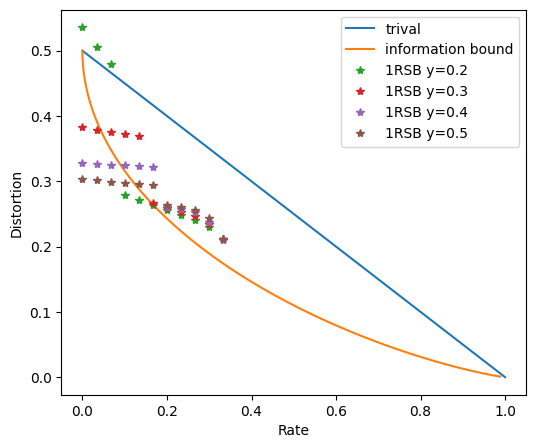

PyObject <matplotlib.legend.Legend object at 0x7f2d93152730>

In [590]:
using PyPlot
H(p)=1+p*log2(p)+(1-p)*log2(1-p)
fig, ax = subplots(figsize=(6,5))
xlabel("Rate")
ylabel("Distortion")
plot((0,1),(0.5,0), label="trival")
plot(H.(0:0.001:0.5), 0:0.001:0.5, label="information bound")
plot(R2,D2, "*", label="1RSB y=0.2")
plot(R3,D3, "*", label="1RSB y=0.3")
plot(R4,D4, "*", label="1RSB y=0.4")
plot(R5,D5, "*", label="1RSB y=0.5")
legend()